<a href="https://colab.research.google.com/github/22032300-Faiz-Shafie/FoodExpiryDetectorApp/blob/main/StableDiffusionV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART 1: SAM

In [2]:
!nvidia-smi

Sat Jun  1 05:26:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install Segment Anything Model (SAM) and other dependencies

In [3]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [4]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

### Download SAM weights

In [5]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [6]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [7]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [8]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [10]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
import os

IMAGE_NAME = "Papaya_1.jpg"
IMAGE_PATH = "/content/Papaya_1.jpg"

### Generate masks with SAM

In [12]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [13]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

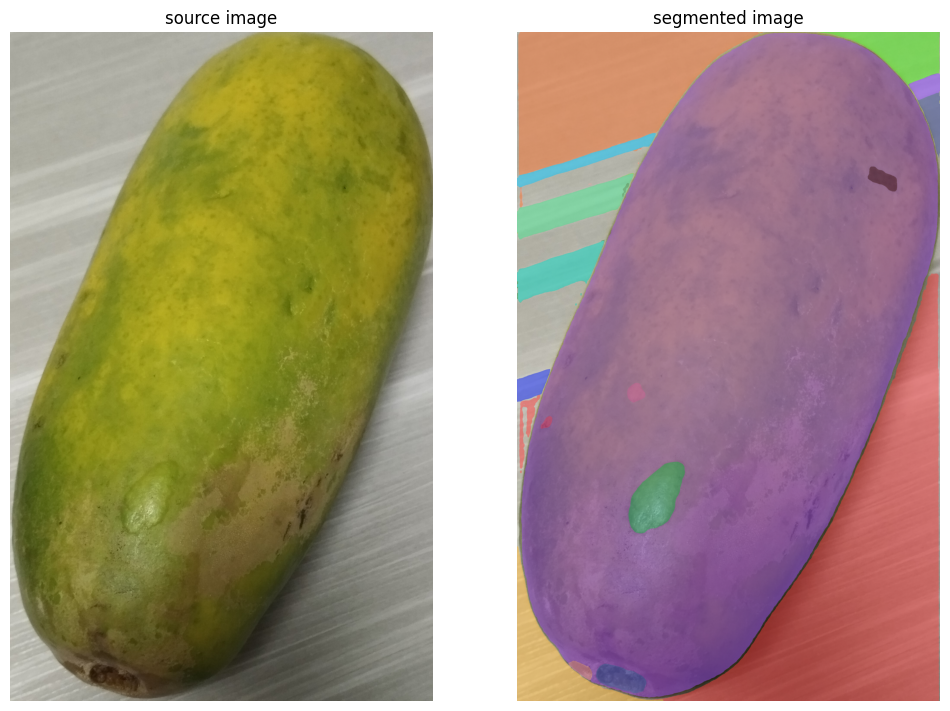

In [14]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [15]:
mask_predictor = SamPredictor(sam)

In [16]:
import os

IMAGE_NAME = "Papaya_1.jpg.jpeg"
IMAGE_PATH = "/content/Papaya_1.jpg"

### Draw Box



In [17]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [18]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [19]:
widget.bboxes

[]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [20]:
import numpy as np
from PIL import Image

with Image.open(IMAGE_PATH) as img:
    image_width, image_height = img.size

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 0, 'y': -1, 'width': image_width, 'height': image_height, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [21]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)
selected_mask = masks[-1]
mask_image = (selected_mask * 255).astype(np.uint8)  # Convert to uint8 format
cv2.imwrite('/content/mask.jpg', mask_image)

True

### Results visualisation with Supervision

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


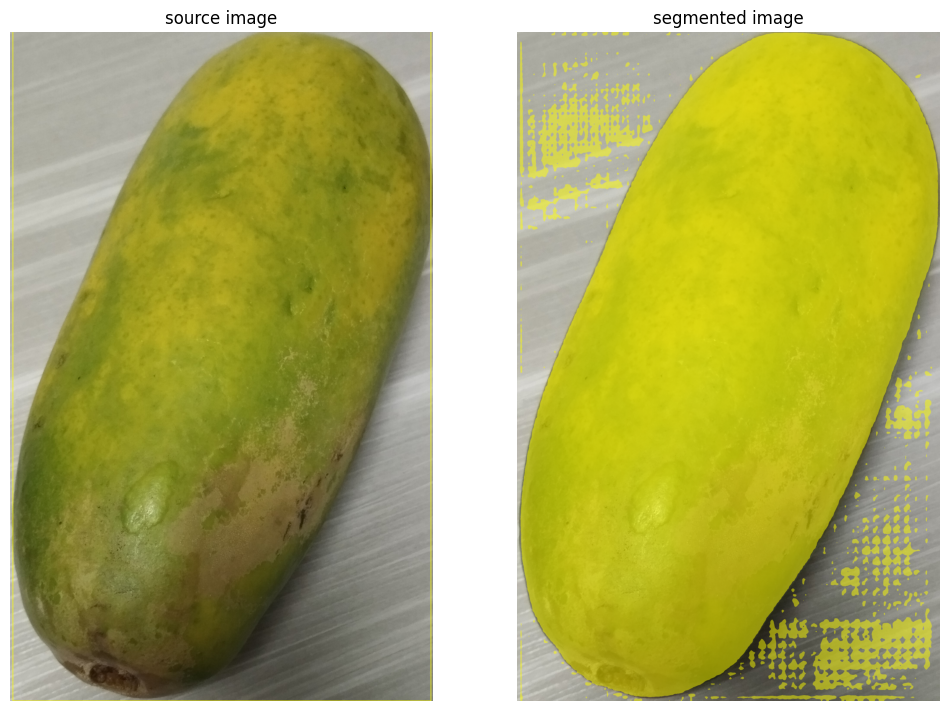

In [22]:
box_annotator = sv.BoxAnnotator(color=sv.Color(r=255, g=255, b=0))
mask_annotator = sv.MaskAnnotator(color=sv.Color(r=255, g=255, b=0), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [23]:
import cv2
cv2.imwrite("/content/hi.jpg", segmented_image)


True

### Interaction with segmentation results

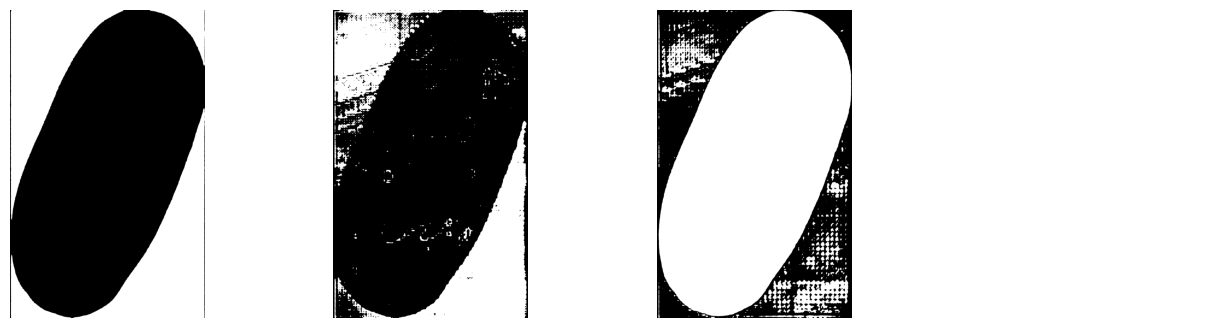

In [24]:
import supervision as sv

sv.plot_images_grid(
    images=masks,
    grid_size=(1,4),
    size=(16, 4)
)



In [25]:
import cv2
cv2.imwrite("/content/hi.jpg", segmented_image)

True

# PART 2: StableDiffusion (currently using inpainting, might switch to img2img depending on which is better)

The [StableDiffusionImg2ImgPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/img2img#diffusers.StableDiffusionImg2ImgPipeline) allows stableDiffusion to be used. We will be using the repaint functionality

In [26]:
#I'm not sure all the installations here are neccesary
!pip install diffusers transformers ftfy accelerate
!pip install -Uqqq
!pip -qqq install bitsandbytes accelerate

ERROR: You must give at least one requirement to install (see "pip help install")


Uses [Inpainting](https://huggingface.co/docs/diffusers/en/using-diffusers/inpaint) with a pretrained Stable Diffusion model

In [27]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForInpainting.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16,low_cpu_mem_usage=True
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
#pipeline.enable_xformers_memory_efficient_attention()

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

here the image of the fruit and the mask is loaded:

In [28]:
from PIL import Image

#Load image of fruit
image_name="Papaya_1.jpg"
image_path="/content/" + image_name
init_image =load_image((Image.open(image_path)))
init_image.thumbnail((768, 768))
init_image

#load mask of fruit
mask_image =load_image(Image.open("/content/mask.jpg"))


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

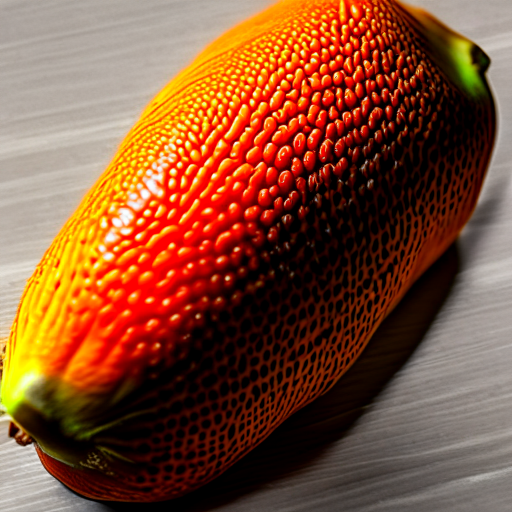

In [32]:
#should use Lora to make image output better
pipeline.safety_checker = None
pipeline.requires_safety_checker = False
prompt = "orange papaya that is overripe with dark spots"
negative_prompt = "logo,thumbnail"
image = pipeline(prompt=prompt, negative_prompt=negative_prompt, image=init_image, mask_image=mask_image).images[0]
make_image_grid([image], rows=1, cols=1)